In [1]:
pip install TableauScraper

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests, time
from math import sin, asin, cos, sqrt, radians
import numpy as np
import matplotlib
import pylab
import seaborn as sns
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import great_circle, geodesic
from collections import defaultdict

In [3]:
from tableauscraper import TableauScraper as TS

url = "https://public.tableau.com/views/InternationalhumanitarianaidinUkraine/ENGdashboard?:showVizHome=no"

ts = TS()
ts.loads(url)
workbook = ts.getWorkbook()

for t in workbook.worksheets:
    print(f"worksheet name : {t.name}") #show worksheet name
    print(t.data) #show dataframe for this worksheet

worksheet name : Sheet 5
   SUM(Вага, т)-alias
0        898980.84521
worksheet name : Sheet 5 (2)
   CNT(Вага, т)-alias
0              149981
worksheet name : Отримувачі гуманітарки
     COLLECT(Geometry)-alias         ADMIN_1-alias      ADMIN_3-alias  \
0        5709502431550126797       Сумська область  Зноб-Новгородська   
1       11152669815422936989  Чернігівська область        Семенівська   
2        2487719945875751117       Сумська область        Дружбівська   
3       13582824748672333069       Сумська область         Ямпільська   
4        8229574966191498674  Чернігівська область       Городнянська   
...                      ...                   ...                ...   
1068    17757481284078875793       Одеська область       Саф’янівська   
1069     8353070472132886832       Одеська область         Вилківська   
1070    11679755357849403194       Одеська область        Ізмаїльська   
1071    11679755357849403194       Одеська область        Ізмаїльська   
1072     133023

In [4]:
# show original data for worksheet
ws = ts.getWorksheet("Отримувачі гуманітарки")
df = pd.DataFrame(ws.data)
display(df)

,COLLECT(Geometry)-alias,ADMIN_1-alias,ADMIN_3-alias,Transport type-value,Transport type-alias,adm_1_eng-value,adm_1_eng-alias,adm_3_eng-value,adm_3_eng-alias,"SUM(Населення, тис.)-alias",SUM(Тон допомоги на тисячу населення)-alias,"SUM(Вага, т)-alias",Latitude (generated)-value,Latitude (generated)-alias,Longitude (generated)-value,Longitude (generated)-alias,ATTR(Тип транспорту)-alias,AGG(К-сть вантажів)-alias
0,5709502431550126797,Сумська область,Зноб-Новгородська,Automobile,Automobile,Sumska,Sumska,Znob-Novgorodska,Znob-Novgorodska,4.828,3.881762,1.7,52.244519,52.245,33.546371,33.55,Автомобільний,1
1,11152669815422936989,Чернігівська область,Семенівська,Automobile,Automobile,Chernihivska,Chernihivska,Semenivska,Semenivska,15.973,6.290533,6.022,52.142891,52.143,32.621228,32.62,Автомобільний,2
2,2487719945875751117,Сумська область,Дружбівська,Automobile,Automobile,Sumska,Sumska,Druzhbivska,Druzhbivska,5.406,3.881762,1.712,52.040402,52.040,33.956035,33.96,Автомобільний,1
3,13582824748672333069,Сумська область,Ямпільська,Automobile,Automobile,Sumska,Sumska,Yampilska,Yampilska,8.153,3.881762,8.82,51.96909,51.969,33.741536,33.74,Автомобільний,1
4,8229574966191498674,Чернігівська область,Городнянська,Automobile,Automobile,Chernihivska,Chernihivska,Gorodnyanska,Gorodnyanska,21.388,6.290533,2.688,51.95544,51.955,31.524671,31.52,Автомобільний,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,17757481284078875793,Одеська область,Саф’янівська,Automobile,Automobile,Odeska,Odeska,Safyanivska,Safyanivska,42.588,9.858124,124.8844,45.450398,45.450,28.904314,28.90,Автомобільний,125
1069,8353070472132886832,Одеська область,Вилківська,Automobile,Automobile,Odeska,Odeska,Vylkivska,Vylkivska,12.723,9.858124,5.471,45.448624,45.449,29.61591,29.62,Автомобільний,2
1070,11679755357849403194,Одеська область,Ізмаїльська,Automobile,Automobile,Odeska,Odeska,Izmailska,Izmailska,70.731,9.858124,640.560469,45.358574,45.359,28.843599,28.84,Автомобільний,324
1071,11679755357849403194,Одеська область,Ізмаїльська,Maritime,Maritime,Odeska,Odeska,Izmailska,Izmailska,70.731,9.858124,269.6,45.358574,45.359,28.843599,28.84,Морський,2


In [5]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
def haversine(lonlat1, lonlat2):

    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [7]:
def find_nearest_target_point(clusters_center, target_points):
    target = {}
    for label, center in clusters_center.items():
        dmin = float('inf')
        closest_point = None
        for target_point in target_points:
            distance = haversine(center, target_point)
            if distance < dmin:
                dmin = distance
                closest_point = target_point

        target[label] = closest_point

    return target

In [8]:
# boder point data source : https://data.humdata.org/dataset/ukraine-border-crossings
border_df = pd.read_excel(r'E:\paper\data\geojason\ukr_border_crossings_20230530.xlsx', sheet_name='Border Crossings')
display(border_df)

,Name_ENG,Name_UKR,Country,Type,Status,Lat,Lon,Status as of
0,Vilcha - Oleksandrivka,Вільча - Олександрівка,Belarus,Road,Closed,51.375612,29.409339,2023-05-30
1,Vystupovychi - Nova Rudnia,Виступовичі - Нова Рудня,Belarus,Road,Closed,51.516881,28.985531,2023-05-30
2,Maidan-Kopyshchanskyi - Hlushkevychi,Майдан-Копищанський - Глушкевичі,Belarus,Road,Closed,51.539146,27.845577,2023-05-30
3,Novi Yarylovychi - Nova Huta,Нові Яриловичі - Нова Гута,Belarus,Road,Closed,52.074702,30.969933,2023-05-30
4,Slavutych - Komaryn,Славутич - Комарин,Belarus,Road,Closed,51.399221,30.657726,2023-05-30
...,...,...,...,...,...,...,...,...
123,Yuhanivka - Yelan,Юганівка - Єлань,Russian Federation,Road,Closed,48.687488,39.717300,2023-05-30
124,Novoborovytsi - Alekseevo-Tuzlovka,Новоборовиці - Алєксєєво-Тузловка,Russian Federation,Road,Closed,47.859815,39.478740,2023-05-30
125,Uzhhorod - Vyšné Nemecké,Ужгород - Вишнє Нємецьке,Slovakia,Road,Operational,48.653606,22.265710,2023-05-30
126,Malyi Bereznyi - Ubľa,Малий Березний - Убля,Slovakia,Road,Operational,48.883723,22.420635,2023-05-30


{0: [50.27338488, 23.58982299], 1: [51.399221, 30.657726], 2: [51.3756116, 29.4093392], 3: [50.29801682, 36.28183012], 4: [47.87771135, 29.27498873], 5: [48.44485856, 27.79135141], 6: [50.36827375, 35.75717961], 7: [46.38315714, 30.08739523]}


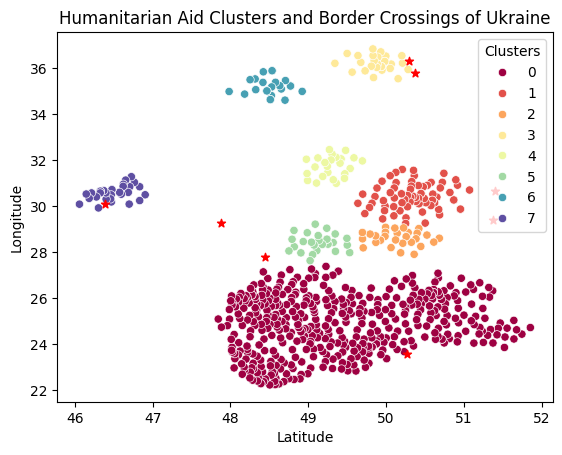

In [9]:
if __name__ == "__main__":
    # Get latitude and longitude points from dataset
    latitude_column = 'Latitude (generated)-value'
    longitude_column = 'Longitude (generated)-value'
    X = df[[latitude_column, longitude_column]].values.tolist()
    city = df[['adm_1_eng-value','adm_3_eng-value',latitude_column, longitude_column]].values.tolist()
    border = border_df[['Lat', 'Lon']].values.tolist()
    clusters = []
    city_out = []

    # Set up DBSCAN clustering
    kms_per_radian = 6371.0088
    db = DBSCAN(eps=40/ kms_per_radian, min_samples=15, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
    cluster_labels = db.labels_
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

    # Assign points to clusters
    for i in range(len(cluster_labels)):
        for j in range(n_clusters):
            if cluster_labels[i] == j:
                X[i].append(j)
                clusters.append(X[i])
                city[i].append(j)
                city_out.append(city[i])

    # Organize clusters by label
    each_cluster = defaultdict(list)
    w0 = each_cluster[0]
    w1 = each_cluster[1]
    for point in clusters:
        label = point[2]
        each_cluster[label].append(point[:2])

    # Calculate cluster centers
    centers = {}
    for label, points in each_cluster.items():
        if points:  # If the tag has corresponding points
            mean_longitude = sum(p[0] for p in points) / len(points)
            mean_latitude = sum(p[1] for p in points) / len(points)
            centers[label] = [mean_longitude, mean_latitude]
        
    # Find the nearest border point for each cluster
    nearest_point = find_nearest_target_point(centers, border)
    print(nearest_point)  #Output the coordinates of each cluster's corresponding checkpoint

    # Visualize
    df_out= pd.DataFrame(clusters, columns=['Latitude', 'Longitude', 'label'])
    p=sns.scatterplot(data=df_out,x='Latitude',y='Longitude',hue='label', legend = "full", palette = "Spectral")
    sns.move_legend(p,'upper right', bbox_to_anchor=(1.0, 1.0), title = 'Clusters')

    for label, coordinates in nearest_point.items():
        latitude, longitude = coordinates
        plt.scatter(latitude, longitude, marker='*', color='red')
   
    plt.title('Humanitarian Aid Clusters and Border Crossings of Ukraine')
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    plt.show()

In [10]:
# Convert nearest_point to DataFrame
nearest_point_df = pd.DataFrame(list(nearest_point.items()), columns=['label', 'Coordinates'])
nearest_point_df[['Latitude', 'Longitude']] = pd.DataFrame(nearest_point_df['Coordinates'].tolist(), index=nearest_point_df.index)
nearest_point_df.drop(columns=['Coordinates'], inplace=True)

print(nearest_point_df)

print(df_out)

   label   Latitude  Longitude
0      0  50.273385  23.589823
1      1  51.399221  30.657726
2      2  51.375612  29.409339
3      3  50.298017  36.281830
4      4  47.877711  29.274989
5      5  48.444859  27.791351
6      6  50.368274  35.757180
7      7  46.383157  30.087395
      Latitude  Longitude  label
0    51.854924  24.728774      0
1    51.746036  24.443565      0
2    51.678087  24.631711      0
3    51.643766  24.233541      0
4    51.642622  25.040106      0
..         ...        ...    ...
684  46.277007  30.396477      7
685  46.214615  30.570521      7
686  46.184180  30.334643      7
687  46.146412  30.523266      7
688  46.059092  30.083300      7

[689 rows x 3 columns]


In [11]:
clustering_result_df = df_out.merge(nearest_point_df, on=['label'])
clustering_result_df = clustering_result_df.rename(columns={
    'Latitude_x': 'Hromadas_Latitude',
    'Longitude_x': 'Hromadas_Longitude',
    'Latitude_y': 'Boder_Latitude',
    'Longitude_y': 'Boder_Longitude'
})
display(clustering_result_df)

,Hromadas_Latitude,Hromadas_Longitude,label,Boder_Latitude,Boder_Longitude
0,51.854924,24.728774,0,50.273385,23.589823
1,51.746036,24.443565,0,50.273385,23.589823
2,51.678087,24.631711,0,50.273385,23.589823
3,51.643766,24.233541,0,50.273385,23.589823
4,51.642622,25.040106,0,50.273385,23.589823
...,...,...,...,...,...
684,46.277007,30.396477,7,46.383157,30.087395
685,46.214615,30.570521,7,46.383157,30.087395
686,46.184180,30.334643,7,46.383157,30.087395
687,46.146412,30.523266,7,46.383157,30.087395


In [13]:
df_copy = df.copy().rename(columns={
    'Latitude (generated)-value': 'Hromadas_Latitude',
    'Longitude (generated)-value': 'Hromadas_Longitude',
})


# merge the dataset
merge_result_df = clustering_result_df.merge(df_copy, on=['Hromadas_Latitude', 'Hromadas_Longitude'], how='left')
merge_result_df = merge_result_df.drop(columns=[
    'COLLECT(Geometry)-alias','ADMIN_1-alias','ADMIN_3-alias','Transport type-alias',
    'adm_3_eng-alias','adm_1_eng-alias','Latitude (generated)-alias','Longitude (generated)-alias',
    'ATTR(Тип транспорту)-alias','SUM(Тон допомоги на тисячу населення)-alias','SUM(Населення, тис.)-alias'
])

merge_result_df = merge_result_df.rename(columns={
    'adm_1_eng-value': 'Oblast',
    'adm_3_eng-value': 'Hromadas',
    'SUM(Вага, т)-alias': 'Weight,tone',
    'AGG(К-сть вантажів)-alias': 'Number of supplies'
})

display(merge_result_df)

,Hromadas_Latitude,Hromadas_Longitude,label,Boder_Latitude,Boder_Longitude,Transport type-value,Oblast,Hromadas,"Weight,tone",Number of supplies
0,51.854924,24.728774,0,50.273385,23.589823,Automobile,Volynska,Samarivska,0.64,1
1,51.746036,24.443565,0,50.273385,23.589823,Automobile,Volynska,Ratnivska,66.4862,19
2,51.678087,24.631711,0,50.273385,23.589823,Automobile,Volynska,Zabrodivska,47.686,24
3,51.643766,24.233541,0,50.273385,23.589823,Automobile,Volynska,Zabolottivska,120.868,14
4,51.642622,25.040106,0,50.273385,23.589823,Automobile,Volynska,Kamin-Kashyrska,302.606501,209
...,...,...,...,...,...,...,...,...,...,...
784,46.277007,30.396477,7,46.383157,30.087395,Automobile,Odeska,Ovidiopolska,3.1865,2
785,46.214615,30.570521,7,46.383157,30.087395,Automobile,Odeska,Dalnytska,7.679,8
786,46.18418,30.334643,7,46.383157,30.087395,Automobile,Odeska,Bilgorod-Dnistrovska,469.36038,84
787,46.146412,30.523266,7,46.383157,30.087395,Automobile,Odeska,Karolino-Bugazka,1.658,1
